# Fitting with Auto TS

In [3]:
from setup import start_spark, extract_data

spark = start_spark(sesh_name = 'Jupyter Sktime Modelling')
train, val = extract_data(spark)
spark.stop()


In [2]:
from auto_ts import auto_timeseries

Imported auto_timeseries version:0.0.36. Call by using:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



In [5]:
train['pickup_date'] = train.index

In [4]:
ts_column = 'pickup_date'
target = 'total_rides'

In [6]:
model = auto_timeseries(score_type='rmse',
                time_interval='D',
                non_seasonal_pdq=None, seasonality=True, seasonal_period=7,
                model_type=['best'],
                verbose=2)

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |      -4.85693708553701       |
|           p-value           |    4.2268805576492357e-05    |
|          #Lags Used         |             14.0             |
| Number of Observations Used |            715.0             |
|     Critical Value (1%)     |     -3.4395289262948894      |
|     Critical Value (5%)     |     -2.8655907692307694      |
|     Critical Value (10%)    |     -2.5689271030368235      |
+-----------------------------+------------------------------+
 this series is stationary
    Target variable given as = total_rides
Start of loading of data.....
Input is data frame. Performing Time Series Analysis


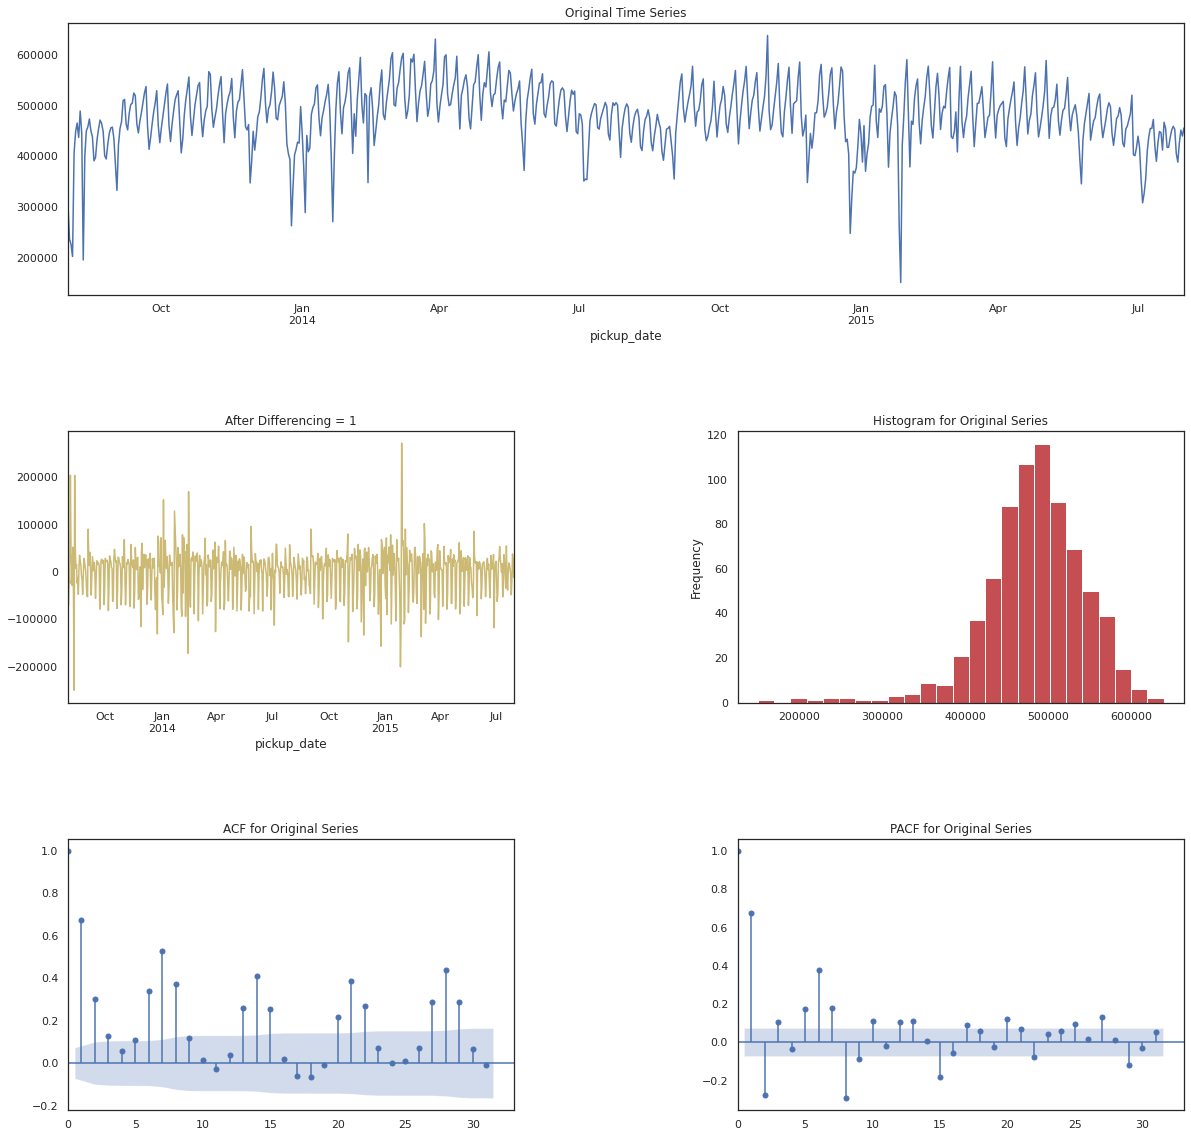

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(730, 3)) with Confidence Interval = 0.95...
  Starting Prophet Fit
       Adding daily seasonality to Prophet with period=7, fourier_order=15 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 3

Fold Number: 1 --> Train Shape: 715 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 44,282.54
    Std Deviation of actuals = 22,707.24
    Normalized RMSE = 195%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 720 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 34,777.78
    Std Deviation of actuals = 19,443.16
    Normalized RMSE = 179%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 725 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 22,213

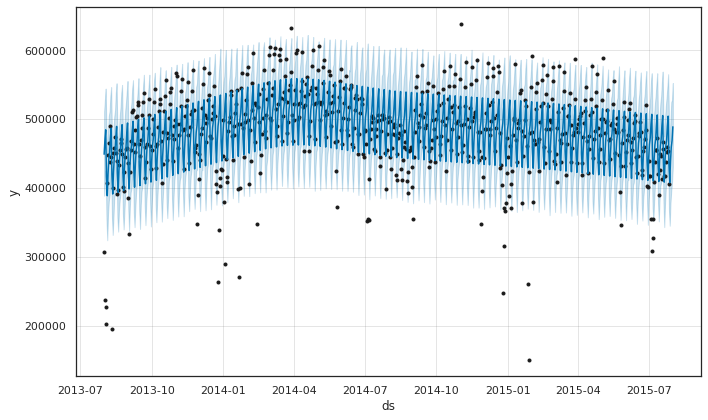

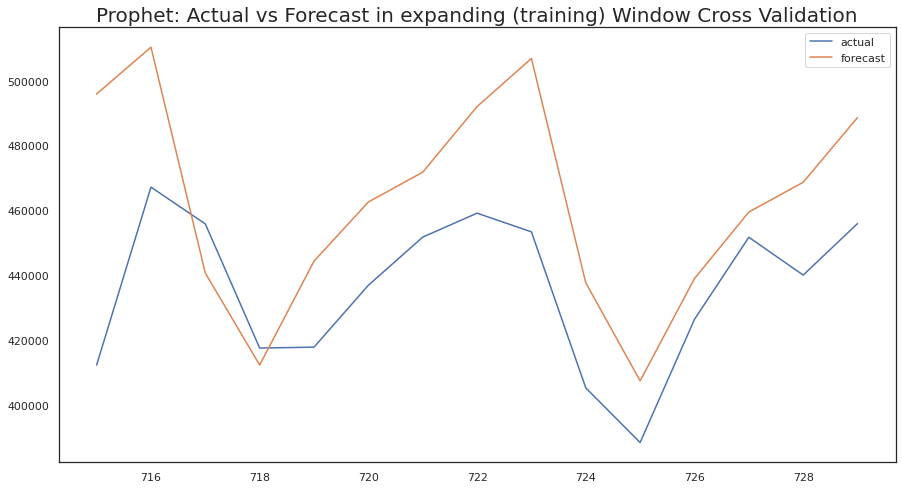

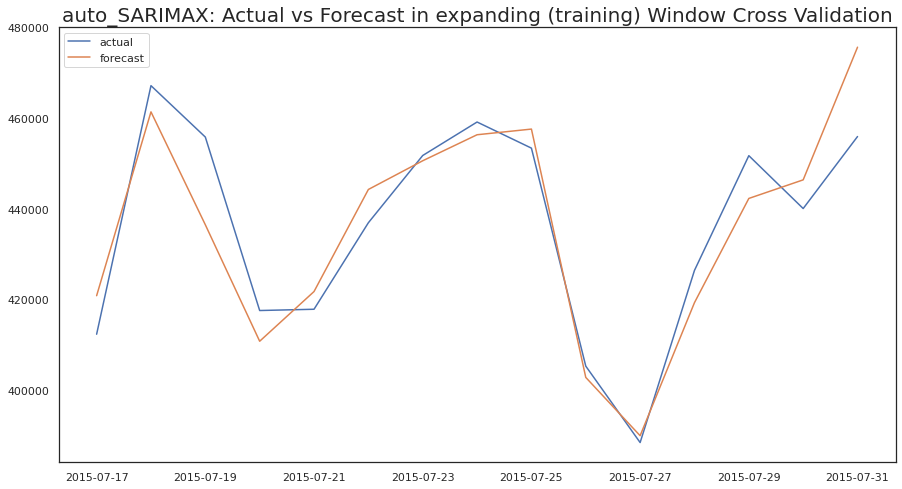

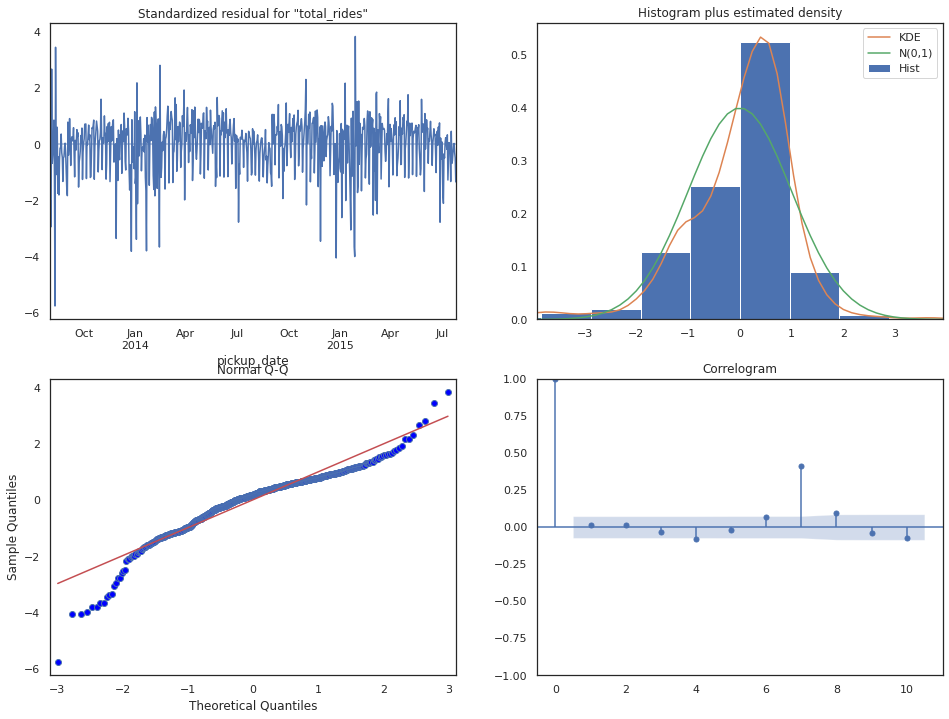

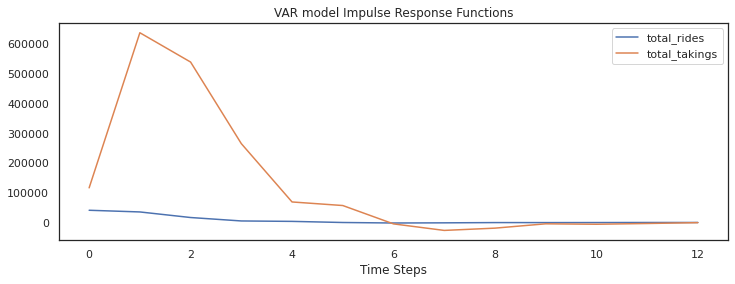

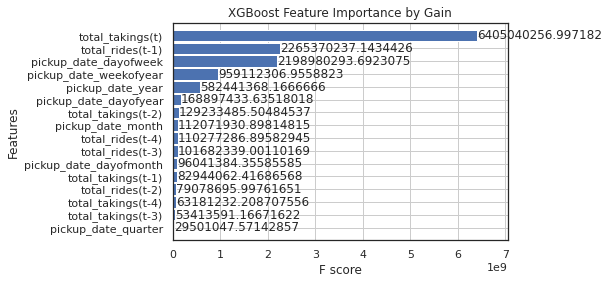

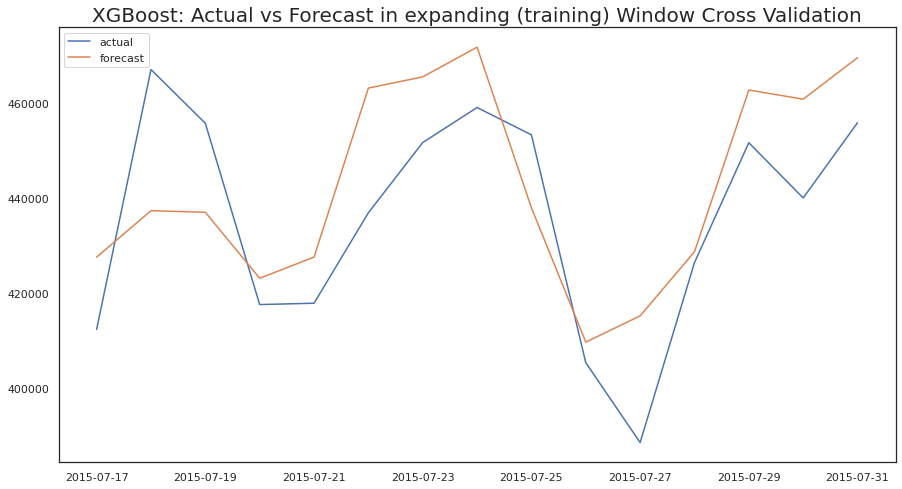

In [7]:
model.fit(
    traindata=train,
    # traindata=file_path,  # Alternately, you can specify the file directly
    ts_column=ts_column,
    target=target,
    cv=3)

# Check Results

In [8]:
model.get_leaderboard()

,name,rmse
1,auto_SARIMAX,8419.030106
3,ML,17053.353419
2,VAR,25698.157412
0,Prophet,33758.080171


<AxesSubplot:xlabel='Model', ylabel='CV Scores'>

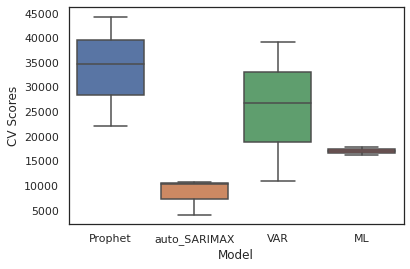

In [9]:
model.plot_cv_scores()

In [10]:
# Make sure all models have the same number of CV folds
model.get_cv_scores()

,Model,CV Scores
0,Prophet,44282.538076
1,Prophet,34777.780610
2,Prophet,22213.921827
3,auto_SARIMAX,10404.235704
4,auto_SARIMAX,4170.563770
5,auto_SARIMAX,10682.290844
6,VAR,39267.736564
7,VAR,26819.911602
8,VAR,11006.824070
9,ML,17881.863434


# Forecast Results

In [13]:
FORECAST_PERIOD = len(val)

In [19]:
val.head()

,total_rides,total_takings
pickup_date,,
2015-08-01,457430,7.044198e+06
2015-08-02,405241,6.453148e+06
2015-08-03,390578,6.272440e+06
2015-08-04,418718,6.678844e+06
2015-08-05,435400,7.002779e+06


In [16]:
# Using Best Model
future_predictions = model.predict(
    testdata=val
)  
future_predictions.head(10)

total_rides,yhat,mean_se,mean_ci_lower,mean_ci_upper
2015-08-01,444054.084335,22829.711098,399308.672805,488799.495865
2015-08-02,397135.041096,29074.322186,340150.416737,454119.665454
2015-08-03,381465.322315,32110.795806,318529.319022,444401.325609
2015-08-04,406149.932926,33266.631958,340948.532402,471351.333451
2015-08-05,424063.116759,34672.432441,356106.397917,492019.835600
2015-08-06,423999.953189,35743.799671,353943.393163,494056.513214
2015-08-07,424296.324786,37226.786922,351333.163157,497259.486414
2015-08-08,400396.301023,42397.858503,317298.025334,483494.576711
2015-08-09,360401.400776,46506.493536,269250.348399,451552.453153
2015-08-10,342846.550514,49154.211603,246506.066083,439187.034945


## Plot Results

In [27]:
import pandas as pd
raw_data = pd.concat([train, val])
raw_data.head()

,total_rides,total_takings,pickup_date
pickup_date,,,
2013-08-01,307272,4.567414e+06,2013-08-01
2013-08-02,236761,3.534616e+06,2013-08-02
2013-08-03,226554,3.182267e+06,2013-08-03
2013-08-04,202310,3.073609e+06,2013-08-04
2013-08-05,406487,6.657713e+06,2013-08-05


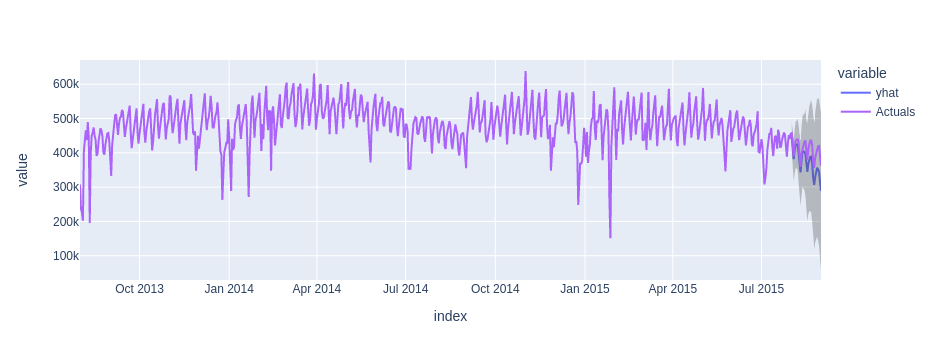

In [38]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(future_predictions, x=future_predictions.index, y=['yhat'])

# , 'mean_ci_lower', 'mean_ci_upper'
fig.add_trace(go.Scatter(
        name='Upper Bound',
        x=future_predictions.index,
        y=future_predictions['mean_ci_upper'],
        mode='lines',
        line=dict(width=0),
        showlegend=False
    ))
fig.add_trace(go.Scatter(
        name='Lower Bound',
        x=future_predictions.index,
        y=future_predictions['mean_ci_lower'],
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        line=dict(width=0),
        showlegend=False
    ))



fig.add_trace(go.Scatter(x = raw_data.index, y=raw_data['total_rides'], name='Actuals'))

fig.show()